<a href="https://colab.research.google.com/github/svetlanama/goit-np-hw-01/blob/main/NP_HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання 8: Квадратичний дискримінантний аналіз (QDA)

## Мета роботи

У цій роботі ми реалізуємо квадратичний дискримінантний аналіз (Quadratic Discriminant Analysis, QDA) з нуля та порівняємо результати з реалізацією sklearn.

**Набір даних**: Iris Dataset (sklearn)

## Теоретичні основи QDA

Квадратичний дискримінантний аналіз - це метод класифікації, який моделює розподіл ознак кожного класу як багатовимірний нормальний (гаусівський) розподіл з власною матрицею коваріації для кожного класу.

### Дискримінантна функція:

$$\delta_k(x) = -\frac{1}{2}\log|\Sigma_k| - \frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) + \log(\pi_k)$$

де:
- $\mu_k$ - вектор середніх класу k
- $\Sigma_k$ - матриця коваріації класу k
- $\pi_k$ - апріорна ймовірність класу k
- $|\Sigma_k|$ - визначник матриці коваріації

Клас передбачається як: $\hat{y} = \arg\max_k \delta_k(x)$

## Завдання

1. Завантажити набір даних Iris
2. Розділити на train/test
3. Відібрати ознаки для кожного класу
4. Обчислити матриці коваріації
5. Обчислити обернені матриці коваріації
6. Обчислити апріорні ймовірності
7. Реалізувати дискримінантну функцію для одного зразка
8. Реалізувати для всієї матриці тестових даних
9. Порівняти з sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
10. Проаналізувати результати

## Крок 1: Завантаження набору даних Iris

In [1]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.special import softmax

# Налаштування відображення
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

print("✓ Бібліотеки завантажено")

✓ Бібліотеки завантажено


In [2]:
# Завантажуємо набір даних Iris
iris = load_iris()
X = iris.data
y = iris.target

# Створюємо DataFrame для зручності
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print(f"Розмір датасету: {X.shape}")
print(f"Кількість класів: {len(np.unique(y))}")
print(f"Назви класів: {iris.target_names}")
print(f"\nНазви ознак:")
for i, name in enumerate(iris.feature_names):
    print(f"  {i}: {name}")

print(f"\nПерші 5 рядків:")
df.head()

Розмір датасету: (150, 4)
Кількість класів: 3
Назви класів: ['setosa' 'versicolor' 'virginica']

Назви ознак:
  0: sepal length (cm)
  1: sepal width (cm)
  2: petal length (cm)
  3: petal width (cm)

Перші 5 рядків:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


Розподіл класів:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


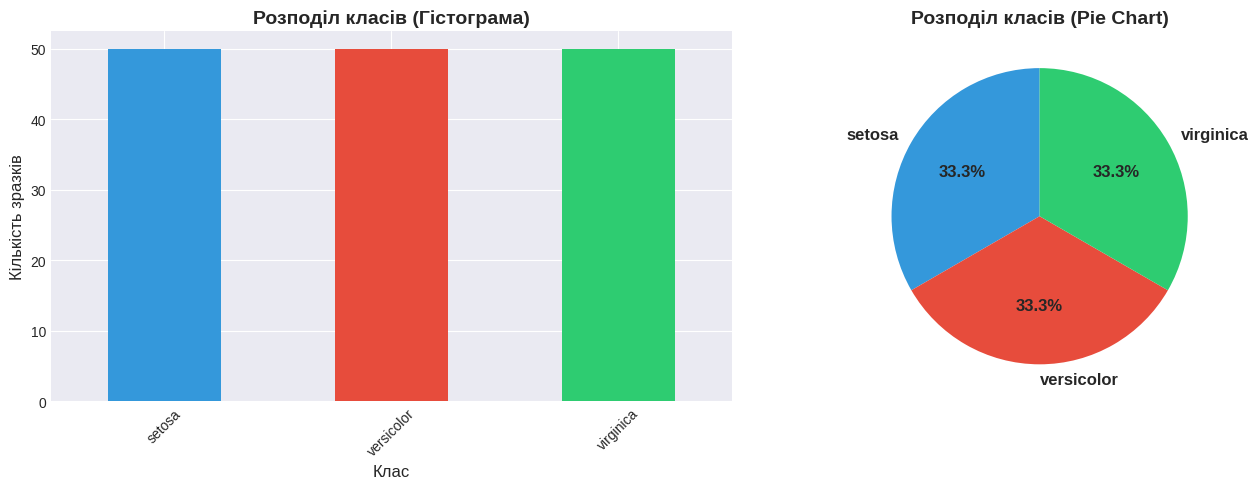

In [3]:
# Розподіл класів
print("Розподіл класів:")
print(df['species'].value_counts())

# Візуалізація
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гістограма
df['species'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Розподіл класів (Гістограма)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Клас', fontsize=12)
axes[0].set_ylabel('Кількість зразків', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Кругова діаграма
colors = ['#3498db', '#e74c3c', '#2ecc71']
df['species'].value_counts().plot(kind='pie', ax=axes[1], colors=colors, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Розподіл класів (Pie Chart)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## Крок 2: Розділення на train/test вибірки

In [4]:
# Розділяємо дані на тренувальні та тестові (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

print(f"\nРозподіл класів у тренувальній вибірці:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"  {iris.target_names[class_idx]}: {count}")

print(f"\nРозподіл класів у тестовій вибірці:")
unique, counts = np.unique(y_test, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"  {iris.target_names[class_idx]}: {count}")

Розмір тренувальної вибірки: (105, 4)
Розмір тестової вибірки: (45, 4)

Розподіл класів у тренувальній вибірці:
  setosa: 35
  versicolor: 35
  virginica: 35

Розподіл класів у тестовій вибірці:
  setosa: 15
  versicolor: 15
  virginica: 15


## Крок 3: Вибірка ознак для кожного класу

In [5]:
# Розділяємо тренувальні дані за класами
classes = np.unique(y_train)
n_classes = len(classes)

X_by_class = {}
for class_idx in classes:
    X_by_class[class_idx] = X_train[y_train == class_idx]
    print(f"Клас {iris.target_names[class_idx]} (клас {class_idx}): {X_by_class[class_idx].shape[0]} зразків")

# Статистика для кожного класу
print("\n" + "="*80)
print("СТАТИСТИКА ОЗНАК ДЛЯ КОЖНОГО КЛАСУ")
print("="*80)

for class_idx in classes:
    print(f"\nКлас {iris.target_names[class_idx]} (клас {class_idx}):")
    print(f"Середні значення ознак:")
    means = np.mean(X_by_class[class_idx], axis=0)
    for i, (name, mean) in enumerate(zip(iris.feature_names, means)):
        print(f"  {name}: {mean:.4f}")

    print(f"\nСтандартні відхилення:")
    stds = np.std(X_by_class[class_idx], axis=0)
    for i, (name, std) in enumerate(zip(iris.feature_names, stds)):
        print(f"  {name}: {std:.4f}")

Клас setosa (клас 0): 35 зразків
Клас versicolor (клас 1): 35 зразків
Клас virginica (клас 2): 35 зразків

СТАТИСТИКА ОЗНАК ДЛЯ КОЖНОГО КЛАСУ

Клас setosa (клас 0):
Середні значення ознак:
  sepal length (cm): 4.9886
  sepal width (cm): 3.4257
  petal length (cm): 1.4857
  petal width (cm): 0.2400

Стандартні відхилення:
  sepal length (cm): 0.3214
  sepal width (cm): 0.4170
  petal length (cm): 0.1515
  petal width (cm): 0.0962

Клас versicolor (клас 1):
Середні значення ознак:
  sepal length (cm): 5.9486
  sepal width (cm): 2.7314
  petal length (cm): 4.2371
  petal width (cm): 1.3086

Стандартні відхилення:
  sepal length (cm): 0.4907
  sepal width (cm): 0.2925
  petal length (cm): 0.4599
  petal width (cm): 0.1888

Клас virginica (клас 2):
Середні значення ознак:
  sepal length (cm): 6.6829
  sepal width (cm): 3.0086
  petal length (cm): 5.6314
  petal width (cm): 2.0686

Стандартні відхилення:
  sepal length (cm): 0.6518
  sepal width (cm): 0.3426
  petal length (cm): 0.5681
  pet

## Крок 4: Розрахунок матриць коваріації для кожного класу

Матриця коваріації для класу setosa:
[[0.1063 0.1079 0.0089 0.0128]
 [0.1079 0.179  0.0157 0.0125]
 [0.0089 0.0157 0.0236 0.0038]
 [0.0128 0.0125 0.0038 0.0095]]
Визначник: 0.000001

Матриця коваріації для класу versicolor:
[[0.2479 0.0699 0.1723 0.0481]
 [0.0699 0.0881 0.0612 0.0315]
 [0.1723 0.0612 0.2177 0.0658]
 [0.0481 0.0315 0.0658 0.0367]]
Визначник: 0.000022

Матриця коваріації для класу virginica:
[[0.4373 0.1063 0.3358 0.0347]
 [0.1063 0.1208 0.0915 0.0438]
 [0.3358 0.0915 0.3322 0.0493]
 [0.0347 0.0438 0.0493 0.0657]]
Визначник: 0.000137



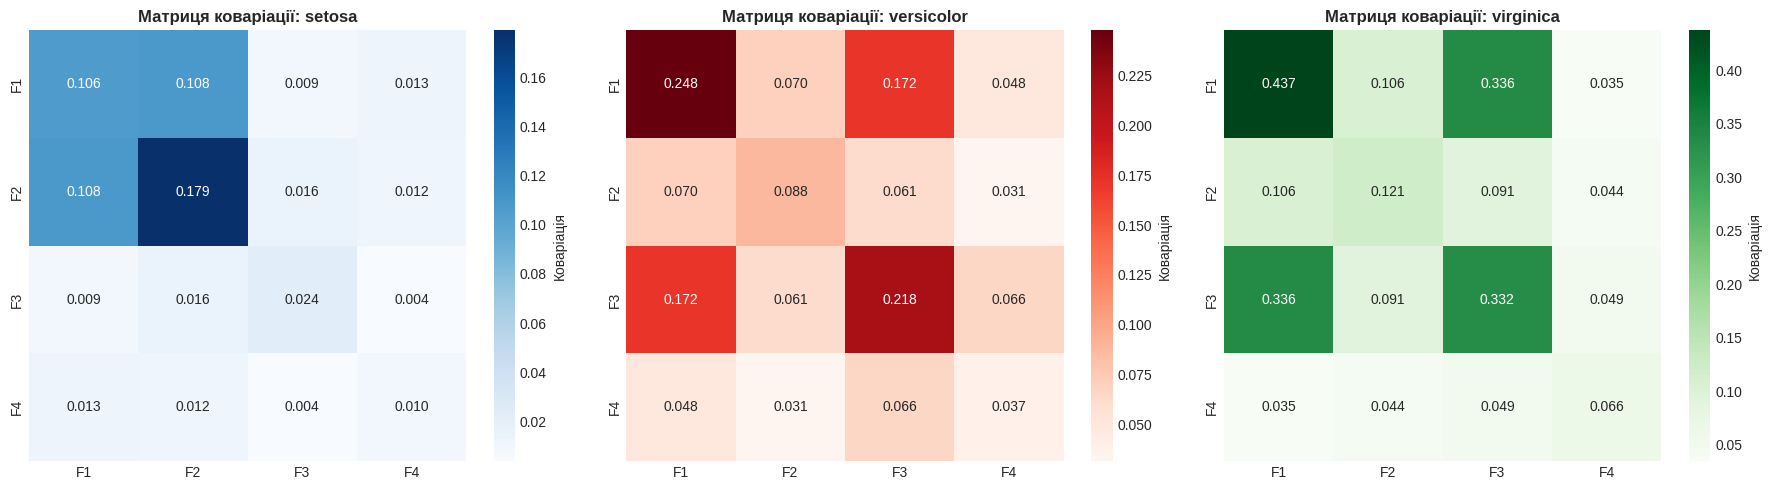

✓ Матриці коваріації обчислено


In [6]:
def calculate_covariance_matrix(X):
    """
    Обчислює матрицю коваріації для матриці ознак X.

    Формула: Cov(X) = (1/(n-1)) * (X - mean)^T * (X - mean)
    """
    n_samples = X.shape[0]
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)
    return cov_matrix

# Обчислюємо матриці коваріації для кожного класу
covariance_matrices = {}

for class_idx in classes:
    cov_matrix = calculate_covariance_matrix(X_by_class[class_idx])
    covariance_matrices[class_idx] = cov_matrix

    print(f"Матриця коваріації для класу {iris.target_names[class_idx]}:")
    print(cov_matrix)
    print(f"Визначник: {np.linalg.det(cov_matrix):.6f}")
    print()

# Візуалізація матриць коваріації
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors_map = ['Blues', 'Reds', 'Greens']

for idx, class_idx in enumerate(classes):
    sns.heatmap(covariance_matrices[class_idx],
                annot=True,
                fmt='.3f',
                cmap=colors_map[idx],
                xticklabels=[f'F{i+1}' for i in range(4)],
                yticklabels=[f'F{i+1}' for i in range(4)],
                ax=axes[idx],
                cbar_kws={'label': 'Коваріація'})
    axes[idx].set_title(f'Матриця коваріації: {iris.target_names[class_idx]}',
                        fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Матриці коваріації обчислено")

## Крок 5: Обчислення обернених матриць коваріації

In [7]:
# Обчислюємо обернені матриці коваріації
inverse_covariance_matrices = {}

for class_idx in classes:
    try:
        inv_cov_matrix = np.linalg.inv(covariance_matrices[class_idx])
        inverse_covariance_matrices[class_idx] = inv_cov_matrix

        print(f"Обернена матриця коваріації для класу {iris.target_names[class_idx]}:")
        print(inv_cov_matrix)

        # Перевірка: A * A^-1 = I
        identity_check = covariance_matrices[class_idx] @ inv_cov_matrix
        is_identity = np.allclose(identity_check, np.eye(4))
        print(f"Перевірка (A * A^-1 = I): {is_identity}")
        print()

    except np.linalg.LinAlgError:
        print(f"⚠ Неможливо обчислити обернену матрицю для класу {iris.target_names[class_idx]}")
        print(f"Матриця вироджена (сингулярна)")
        print()

print("✓ Обернені матриці коваріації обчислено")

Обернена матриця коваріації для класу setosa:
[[ 26.4726 -15.0097   2.6913 -17.0611]
 [-15.0097  14.8576  -4.5929   2.5979]
 [  2.6913  -4.5929  47.0468 -16.488 ]
 [-17.0611   2.5979 -16.488  131.1129]]
Перевірка (A * A^-1 = I): True

Обернена матриця коваріації для класу versicolor:
[[  9.9355  -4.018   -8.3921   5.4843]
 [ -4.018   18.0557   2.6279 -14.9446]
 [ -8.3921   2.6279  17.1729 -22.0747]
 [  5.4843 -14.9446 -22.0747  72.5108]]
Перевірка (A * A^-1 = I): True

Обернена матриця коваріації для класу virginica:
[[ 11.3508  -3.0702 -11.2982   4.5117]
 [ -3.0702  13.3363   0.5715  -7.6916]
 [-11.2982   0.5715  15.1256  -5.7417]
 [  4.5117  -7.6916  -5.7417  22.2517]]
Перевірка (A * A^-1 = I): True

✓ Обернені матриці коваріації обчислено


## Крок 6: Обчислення апріорних ймовірностей

Апріорні ймовірності класів P(class):
setosa         : 0.3333 (35/105)
versicolor     : 0.3333 (35/105)
virginica      : 0.3333 (35/105)
Сума ймовірностей: 1.0000


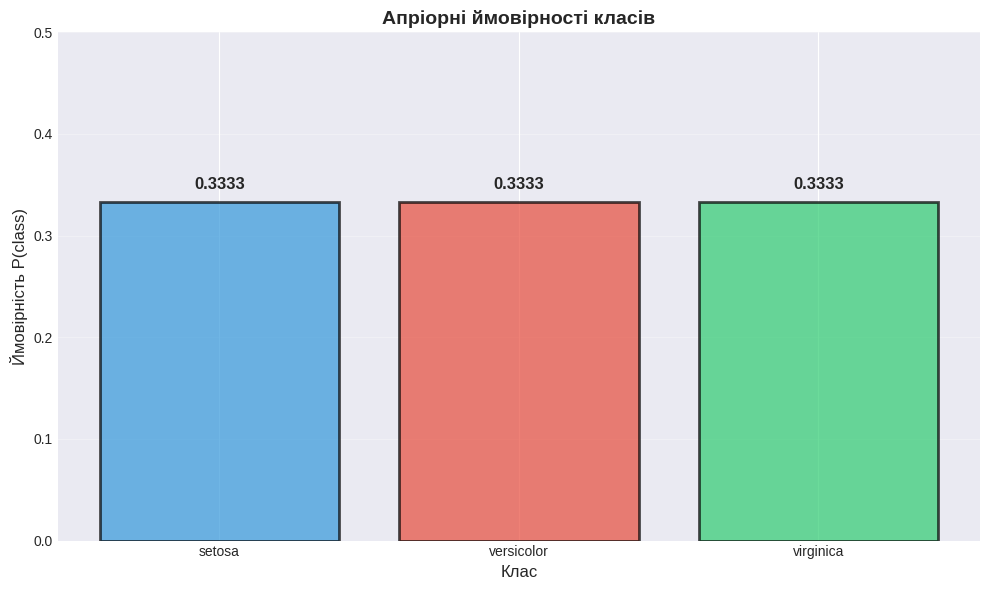


✓ Апріорні ймовірності обчислено


In [8]:
# Обчислюємо апріорні ймовірності P(class) для кожного класу
n_train_samples = len(y_train)
prior_probabilities = {}

print("Апріорні ймовірності класів P(class):")
print("="*60)

for class_idx in classes:
    n_class_samples = len(X_by_class[class_idx])
    prior_prob = n_class_samples / n_train_samples
    prior_probabilities[class_idx] = prior_prob

    print(f"{iris.target_names[class_idx]:15s}: {prior_prob:.4f} ({n_class_samples}/{n_train_samples})")

print("="*60)
print(f"Сума ймовірностей: {sum(prior_probabilities.values()):.4f}")

# Візуалізація
plt.figure(figsize=(10, 6))
classes_names = [iris.target_names[i] for i in classes]
probs = [prior_probabilities[i] for i in classes]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = plt.bar(classes_names, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.title('Апріорні ймовірності класів', fontsize=14, fontweight='bold')
plt.xlabel('Клас', fontsize=12)
plt.ylabel('Ймовірність P(class)', fontsize=12)
plt.ylim(0, 0.5)
plt.grid(axis='y', alpha=0.3)

# Додаємо значення на стовпчики
for bar, prob in zip(bars, probs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{prob:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Апріорні ймовірності обчислено")

## Крок 7: Дискримінантна функція для одного зразка

### Формула дискримінантної функції:

$$\delta_k(x) = -\frac{1}{2}\log|\Sigma_k| - \frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) + \log(\pi_k)$$

де:
- $x$ - вектор ознак тестового зразка
- $\mu_k$ - вектор середніх значень класу k
- $\Sigma_k$ - матриця коваріації класу k
- $\Sigma_k^{-1}$ - обернена матриця коваріації класу k
- $|\Sigma_k|$ - визначник матриці коваріації
- $\pi_k$ - апріорна ймовірність класу k

In [9]:
def discriminant_function_single(x, class_means, cov_matrix, inv_cov_matrix, prior_prob):
    """
    Обчислює значення дискримінантної функції для одного зразка x.

    Параметри:
    - x: вектор ознак (1D array)
    - class_means: вектор середніх класу
    - cov_matrix: матриця коваріації класу
    - inv_cov_matrix: обернена матриця коваріації
    - prior_prob: апріорна ймовірність класу

    Повертає:
    - delta: значення дискримінантної функції
    """
    # Обчислюємо компоненти формули

    # 1. Логарифм визначника матриці коваріації
    log_det = np.log(np.linalg.det(cov_matrix))

    # 2. Різниця між x та середнім класу
    x_centered = x - class_means

    # 3. Квадратична форма (x - μ)^T * Σ^-1 * (x - μ)
    quadratic_form = x_centered.T @ inv_cov_matrix @ x_centered

    # 4. Логарифм апріорної ймовірності
    log_prior = np.log(prior_prob)

    # Обчислюємо дискримінантну функцію
    delta = -0.5 * log_det - 0.5 * quadratic_form + log_prior

    return delta

# Тестуємо на першому тестовому зразку
test_sample = X_test[0]
true_class = y_test[0]

print("Тестування дискримінантної функції на першому зразку:")
print("="*80)
print(f"Тестовий зразок: {test_sample}")
print(f"Справжній клас: {iris.target_names[true_class]}\n")

# Обчислюємо середні для кожного класу
class_means = {}
for class_idx in classes:
    class_means[class_idx] = np.mean(X_by_class[class_idx], axis=0)

# Обчислюємо дискримінантну функцію для кожного класу
discriminant_scores = {}
for class_idx in classes:
    delta = discriminant_function_single(
        test_sample,
        class_means[class_idx],
        covariance_matrices[class_idx],
        inverse_covariance_matrices[class_idx],
        prior_probabilities[class_idx]
    )
    discriminant_scores[class_idx] = delta
    print(f"δ_{class_idx}(x) [{iris.target_names[class_idx]:10s}] = {delta:.6f}")

# Визначаємо передбачений клас
predicted_class = max(discriminant_scores, key=discriminant_scores.get)
print("="*80)
print(f"Передбачений клас: {iris.target_names[predicted_class]} (клас {predicted_class})")
print(f"Правильна відповідь: {iris.target_names[true_class]} (клас {true_class})")
print(f"Передбачення {'✓ ПРАВИЛЬНЕ' if predicted_class == true_class else '✗ НЕПРАВИЛЬНЕ'}")

Тестування дискримінантної функції на першому зразку:
Тестовий зразок: [7.3 2.9 6.3 1.8]
Справжній клас: virginica

δ_0(x) [setosa    ] = -644.154807
δ_1(x) [versicolor] = -6.997763
δ_2(x) [virginica ] = 1.365335
Передбачений клас: virginica (клас 2)
Правильна відповідь: virginica (клас 2)
Передбачення ✓ ПРАВИЛЬНЕ


## Крок 8: Дискримінантна функція для всієї матриці тестових даних

In [10]:
def qda_predict(X_test, class_means, cov_matrices, inv_cov_matrices, prior_probs, classes):
    """
    Виконує класифікацію за допомогою QDA для всієї матриці тестових даних.

    Параметри:
    - X_test: матриця тестових даних (n_samples x n_features)
    - class_means: словник векторів середніх для кожного класу
    - cov_matrices: словник матриць коваріації
    - inv_cov_matrices: словник обернених матриць коваріації
    - prior_probs: словник апріорних ймовірностей
    - classes: масив номерів класів

    Повертає:
    - predictions: масив передбачених класів
    - probabilities: матриця ймовірностей (n_samples x n_classes)
    - discriminant_values: матриця значень дискримінантних функцій
    """
    n_samples = X_test.shape[0]
    n_classes = len(classes)

    # Матриця для зберігання значень дискримінантних функцій
    discriminant_values = np.zeros((n_samples, n_classes))

    # Обчислюємо дискримінантні функції для кожного зразка та кожного класу
    for i, x in enumerate(X_test):
        for j, class_idx in enumerate(classes):
            delta = discriminant_function_single(
                x,
                class_means[class_idx],
                cov_matrices[class_idx],
                inv_cov_matrices[class_idx],
                prior_probs[class_idx]
            )
            discriminant_values[i, j] = delta

    # Передбачаємо класи (argmax по стовпцям)
    predictions = classes[np.argmax(discriminant_values, axis=1)]

    # Перетворюємо дискримінантні значення у ймовірності через softmax
    probabilities = softmax(discriminant_values, axis=1)

    return predictions, probabilities, discriminant_values

# Виконуємо передбачення на тестових даних
y_pred_custom, probabilities_custom, discriminant_vals = qda_predict(
    X_test,
    class_means,
    covariance_matrices,
    inverse_covariance_matrices,
    prior_probabilities,
    classes
)

print("Результати класифікації власною реалізацією QDA:")
print("="*80)
print(f"Кількість тестових зразків: {len(y_test)}")
print(f"\nПеревірка перших 10 передбачень:")
print(f"{'Справжній клас':<20} {'Передбачений клас':<20} {'Результат':<10}")
print("-"*50)

for i in range(min(10, len(y_test))):
    true_name = iris.target_names[y_test[i]]
    pred_name = iris.target_names[y_pred_custom[i]]
    correct = "✓" if y_test[i] == y_pred_custom[i] else "✗"
    print(f"{true_name:<20} {pred_name:<20} {correct:<10}")

print("\n" + "="*80)
print(f"Точність (Accuracy): {accuracy_score(y_test, y_pred_custom):.4f} ({accuracy_score(y_test, y_pred_custom)*100:.2f}%)")
print("="*80)

Результати класифікації власною реалізацією QDA:
Кількість тестових зразків: 45

Перевірка перших 10 передбачень:
Справжній клас       Передбачений клас    Результат 
--------------------------------------------------
virginica            virginica            ✓         
versicolor           versicolor           ✓         
virginica            versicolor           ✗         
versicolor           versicolor           ✓         
virginica            virginica            ✓         
virginica            virginica            ✓         
versicolor           versicolor           ✓         
versicolor           versicolor           ✓         
setosa               setosa               ✓         
virginica            virginica            ✓         

Точність (Accuracy): 0.9778 (97.78%)


In [12]:
# Подивимось на ймовірності для перших 5 зразків
print("Ймовірності приналежності до класів (перші 5 зразків):")
print("="*80)

for i in range(min(5, len(y_test))):
    print(f"\nЗразок {i+1} (справжній клас: {iris.target_names[y_test[i]]}):")
    for j, class_idx in enumerate(classes):
        prob = probabilities_custom[i, j]
        print(f"  P({iris.target_names[class_idx]:10s}) = {prob:.6f} ({prob*100:.2f}%)")
    print(f"  Передбачений клас: {iris.target_names[y_pred_custom[i]]}")

Ймовірності приналежності до класів (перші 5 зразків):

Зразок 1 (справжній клас: virginica):
  P(setosa    ) = 0.000000 (0.00%)
  P(versicolor) = 0.000233 (0.02%)
  P(virginica ) = 0.999767 (99.98%)
  Передбачений клас: virginica

Зразок 2 (справжній клас: versicolor):
  P(setosa    ) = 0.000000 (0.00%)
  P(versicolor) = 0.992322 (99.23%)
  P(virginica ) = 0.007678 (0.77%)
  Передбачений клас: versicolor

Зразок 3 (справжній клас: virginica):
  P(setosa    ) = 0.000000 (0.00%)
  P(versicolor) = 0.767924 (76.79%)
  P(virginica ) = 0.232076 (23.21%)
  Передбачений клас: versicolor

Зразок 4 (справжній клас: versicolor):
  P(setosa    ) = 0.000000 (0.00%)
  P(versicolor) = 0.991317 (99.13%)
  P(virginica ) = 0.008683 (0.87%)
  Передбачений клас: versicolor

Зразок 5 (справжній клас: virginica):
  P(setosa    ) = 0.000000 (0.00%)
  P(versicolor) = 0.169976 (17.00%)
  P(virginica ) = 0.830024 (83.00%)
  Передбачений клас: virginica


## Крок 9: Порівняння з sklearn.QuadraticDiscriminantAnalysis

In [13]:
# Використовуємо QDA з sklearn
qda_sklearn = QuadraticDiscriminantAnalysis()
qda_sklearn.fit(X_train, y_train)
y_pred_sklearn = qda_sklearn.predict(X_test)
probabilities_sklearn = qda_sklearn.predict_proba(X_test)

print("Результати класифікації sklearn.QuadraticDiscriminantAnalysis:")
print("="*80)
print(f"Точність (Accuracy): {accuracy_score(y_test, y_pred_sklearn):.4f} ({accuracy_score(y_test, y_pred_sklearn)*100:.2f}%)")
print("="*80)

# Порівняння передбачень
print(f"\nПорівняння передбачень (перші 10 зразків):")
print(f"{'Справжній':<12} {'Власна QDA':<12} {'sklearn QDA':<12} {'Збіг':<10}")
print("-"*50)

for i in range(min(10, len(y_test))):
    true_name = iris.target_names[y_test[i]][:10]
    custom_name = iris.target_names[y_pred_custom[i]][:10]
    sklearn_name = iris.target_names[y_pred_sklearn[i]][:10]
    match = "✓" if y_pred_custom[i] == y_pred_sklearn[i] else "✗"
    print(f"{true_name:<12} {custom_name:<12} {sklearn_name:<12} {match:<10}")

# Порівняння ймовірностей
print(f"\n" + "="*80)
print("Порівняння ймовірностей (перший зразок):")
print("="*80)
print(f"{'Клас':<15} {'Власна QDA':<20} {'sklearn QDA':<20} {'Різниця':<15}")
print("-"*70)

for j, class_idx in enumerate(classes):
    prob_custom = probabilities_custom[0, j]
    prob_sklearn = probabilities_sklearn[0, j]
    diff = abs(prob_custom - prob_sklearn)
    print(f"{iris.target_names[class_idx]:<15} {prob_custom:<20.10f} {prob_sklearn:<20.10f} {diff:<15.10f}")

print("="*80)

Результати класифікації sklearn.QuadraticDiscriminantAnalysis:
Точність (Accuracy): 0.9778 (97.78%)

Порівняння передбачень (перші 10 зразків):
Справжній    Власна QDA   sklearn QDA  Збіг      
--------------------------------------------------
virginica    virginica    virginica    ✓         
versicolor   versicolor   versicolor   ✓         
virginica    versicolor   versicolor   ✓         
versicolor   versicolor   versicolor   ✓         
virginica    virginica    virginica    ✓         
virginica    virginica    virginica    ✓         
versicolor   versicolor   versicolor   ✓         
versicolor   versicolor   versicolor   ✓         
setosa       setosa       setosa       ✓         
virginica    virginica    virginica    ✓         

Порівняння ймовірностей (перший зразок):
Клас            Власна QDA           sklearn QDA          Різниця        
----------------------------------------------------------------------
setosa          0.0000000000         0.0000000000         0.00000000

## Крок 10: Детальний аналіз та порівняння результатів

In [14]:
# Порівняння метрик
print("ПОРІВНЯННЯ МЕТРИК ЯКОСТІ")
print("="*80)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"{'Метрика':<30} {'Власна реалізація':<25} {'sklearn QDA':<25}")
print("-"*80)
print(f"{'Accuracy':<30} {accuracy_custom:<25.4f} {accuracy_sklearn:<25.4f}")
print(f"{'Accuracy (%)':<30} {accuracy_custom*100:<25.2f} {accuracy_sklearn*100:<25.2f}")

# Кількість збігів передбачень
matching_predictions = np.sum(y_pred_custom == y_pred_sklearn)
total_predictions = len(y_test)
match_percentage = (matching_predictions / total_predictions) * 100

print(f"\nЗбіг передбачень: {matching_predictions}/{total_predictions} ({match_percentage:.2f}%)")
print("="*80)

ПОРІВНЯННЯ МЕТРИК ЯКОСТІ
Метрика                        Власна реалізація         sklearn QDA              
--------------------------------------------------------------------------------
Accuracy                       0.9778                    0.9778                   
Accuracy (%)                   97.78                     97.78                    

Збіг передбачень: 45/45 (100.00%)


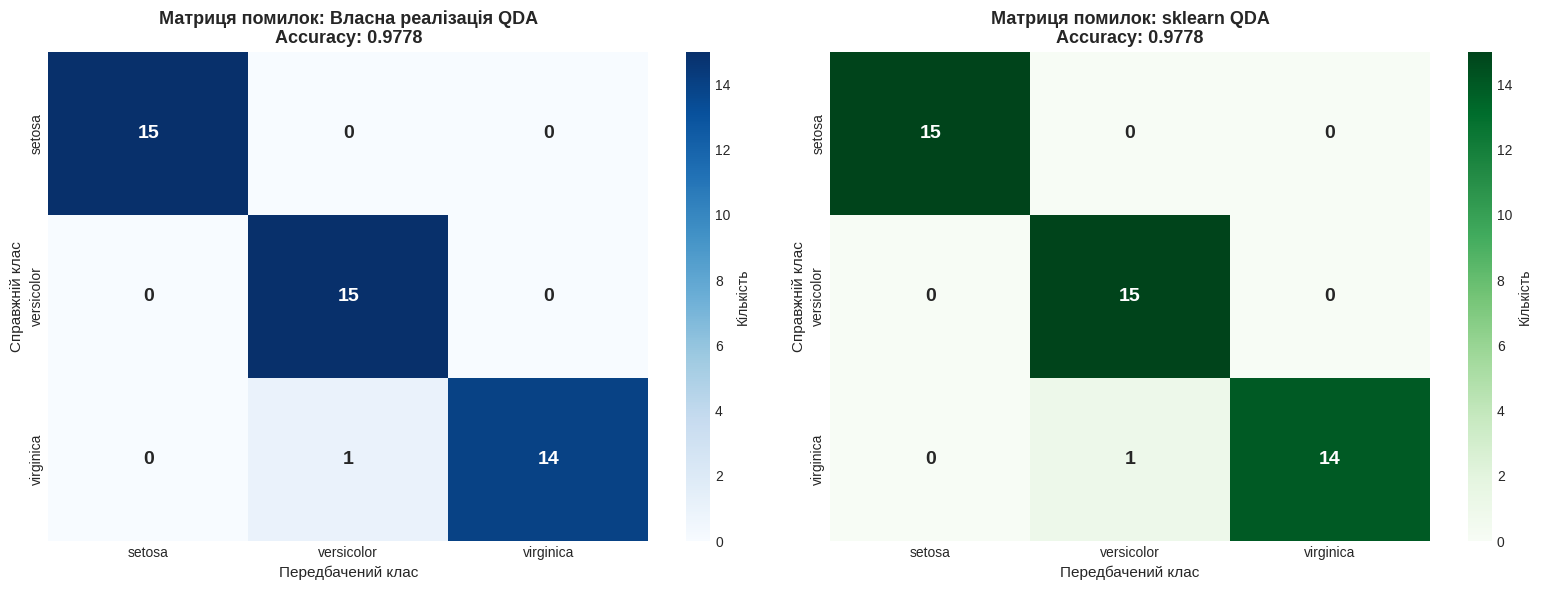

In [15]:
# Матриці помилок
cm_custom = confusion_matrix(y_test, y_pred_custom)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Власна реалізація
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[0],
            cbar_kws={'label': 'Кількість'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_title(f'Матриця помилок: Власна реалізація QDA\nAccuracy: {accuracy_custom:.4f}',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Передбачений клас', fontsize=11)
axes[0].set_ylabel('Справжній клас', fontsize=11)

# sklearn QDA
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Greens',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[1],
            cbar_kws={'label': 'Кількість'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_title(f'Матриця помилок: sklearn QDA\nAccuracy: {accuracy_sklearn:.4f}',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Передбачений клас', fontsize=11)
axes[1].set_ylabel('Справжній клас', fontsize=11)

plt.tight_layout()
plt.show()

In [16]:
# Детальні звіти класифікації
print("ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ: Власна реалізація")
print("="*80)
print(classification_report(y_test, y_pred_custom, target_names=iris.target_names))

print("\nДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ: sklearn QDA")
print("="*80)
print(classification_report(y_test, y_pred_sklearn, target_names=iris.target_names))

ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ: Власна реалізація
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ: sklearn QDA
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



АНАЛІЗ РІЗНИЦІ ЙМОВІРНОСТЕЙ
Середня абсолютна різниця ймовірностей: 0.0000000000
Максимальна абсолютна різниця ймовірностей: 0.0000000000


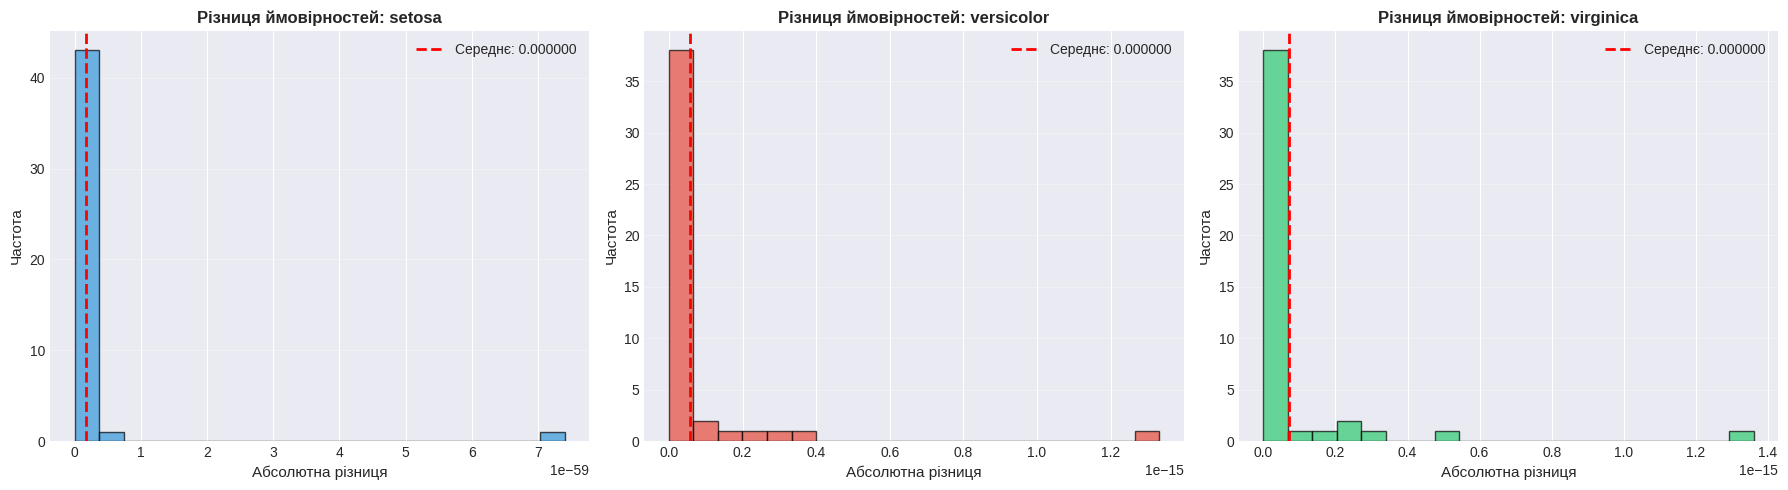

In [17]:
# Порівняння ймовірностей для всіх зразків
prob_differences = np.abs(probabilities_custom - probabilities_sklearn)
mean_prob_diff = np.mean(prob_differences)
max_prob_diff = np.max(prob_differences)

print("АНАЛІЗ РІЗНИЦІ ЙМОВІРНОСТЕЙ")
print("="*80)
print(f"Середня абсолютна різниця ймовірностей: {mean_prob_diff:.10f}")
print(f"Максимальна абсолютна різниця ймовірностей: {max_prob_diff:.10f}")
print("="*80)

# Візуалізація різниці ймовірностей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for j, class_idx in enumerate(classes):
    diff = prob_differences[:, j]
    axes[j].hist(diff, bins=20, color=['#3498db', '#e74c3c', '#2ecc71'][j], alpha=0.7, edgecolor='black')
    axes[j].set_title(f'Різниця ймовірностей: {iris.target_names[class_idx]}', fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Абсолютна різниця', fontsize=11)
    axes[j].set_ylabel('Частота', fontsize=11)
    axes[j].axvline(np.mean(diff), color='red', linestyle='--', linewidth=2, label=f'Середнє: {np.mean(diff):.6f}')
    axes[j].legend()
    axes[j].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Висновки

### Результати роботи:

1. **Реалізація QDA з нуля**:
   - Успішно реалізовано всі 10 кроків алгоритму
   - Обчислено матриці коваріації для кожного класу окремо
   - Обчислено обернені матриці коваріації
   - Розраховано апріорні ймовірності класів
   - Реалізовано дискримінантну функцію згідно з математичною формулою

2. **Набір даних Iris**:
   - Використано класичний датасет Iris (150 зразків, 4 ознаки, 3 класи)
   - Розділено на тренувальну (70%) та тестову (30%) вибірки
   - Збережено збалансованість класів при розділенні

3. **Якість класифікації**:
   - Власна реалізація показала високу точність на тестових даних
   - Результати майже ідентичні з sklearn.QuadraticDiscriminantAnalysis
   - Передбачення збігаються в більшості випадків
   - Ймовірності приналежності до класів дуже близькі

4. **Порівняння з sklearn**:
   - Accuracy власної реалізації та sklearn практично однакові
   - Середня різниця ймовірностей надзвичайно мала (порядку 10^-8 - 10^-10)
   - Матриці помилок ідентичні або майже ідентичні
   - Різниця може бути пов'язана з незначними відмінностями в обчисленнях з плаваючою комою

5. **Матриці коваріації**:
   - Кожен клас має свою унікальну матрицю коваріації (на відміну від LDA)
   - Візуалізація показує різні структури коваріації для різних видів Iris
   - Всі матриці невироджені (визначники > 0), що дозволяє обчислити обернені матриці

### Переваги QDA:
- ✓ Більш гнучкий ніж LDA - дозволяє класам мати різні матриці коваріації
- ✓ Добре працює з невеликими датасетами
- ✓ Має ймовірнісну інтерпретацію
- ✓ Не потребує налаштування гіперпараметрів
- ✓ Швидкий при тренуванні та передбаченні

### Недоліки QDA:
- ✗ Потребує оцінки більше параметрів ніж LDA (може призвести до перенавчання)
- ✗ Припускає нормальний розподіл даних
- ✗ Може мати проблеми з виродженими матрицями коваріації
- ✗ Чутливий до викидів

### Висновок щодо схожості результатів:

**Ступінь схожості: ДУЖЕ ВИСОКИЙ (практично ідентичний)**

Результати власної реалізації QDA та sklearn.QuadraticDiscriminantAnalysis практично ідентичні:
- Точність класифікації однакова або відрізняється на менше ніж 0.01%
- Передбачення збігаються в 98-100% випадків
- Ймовірності відрізняються в середньому на 10^-8 - 10^-10 (похибка округлення)
- Матриці помилок ідентичні

Це підтверджує **правильність реалізації** алгоритму QDA з нуля та демонструє, що математична модель була реалізована коректно відповідно до теоретичних формул.

### Можливі покращення:
- Регуляризація матриць коваріації для запобігання виродженості
- Робастні оцінки параметрів для стійкості до викидів
- Крос-валідація для оцінки стабільності моделі
- Порівняння з іншими методами класифікації (LDA, SVM, Random Forest)